In [1]:
import numpy as np
import pandas as pd
import os
import gc
import csv
import re
%config InlineBackend.figure_format ='retina' #double the resolution for retina displays
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
from sklearn import linear_model
from collections import Counter
#Jupyter setup to expand cell display to 100% width on your screen (optional)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
sns.despine()

<Figure size 432x288 with 0 Axes>

# Data pre-processing

- Drop columns with too large cardinality (> 4 answers)

In [2]:
def get_def(x):
    return(dfss.loc[dfss['Column_name'] == '%s'%x].values[0][3])

dfss=pd.read_csv("Summary.csv")
df=pd.read_hdf("toy_ex.h5")
Culprits=df.columns
L_drop=[]

for item in Culprits:
    if (int(dfss.loc[dfss['Column_name'] == '%s'%item].values[0][5])>4):
        L_drop.append('%s'%item) 
print(len(L_drop))       
df=df.drop(L_drop, axis=1)

75


- Remove rows with low variance (<0.2) and remove outliers (not within 3 sd)

In [4]:
df=df.loc[:, df.std()>0.2]
df=df[df.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]
df=df.loc[:, df.std()>0.2]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60977 entries, 2 to 502542
Columns: 217 entries, 3-0.0 to 30530-0.0
dtypes: float64(217)
memory usage: 101.4 MB


- Remove highly correlated columns ( $|R^{2}|$ > 0.8 )

In [6]:
train_stats = model_selection_dataset.describe()
train_stats.pop("21001-0.0")  #BMI
train_stats = train_stats.transpose()
train_labels = model_selection_dataset.pop('21001-0.0')
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(model_selection_dataset)
corr = normed_train_data.corr()
upper = corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(np.abs(upper[column])> 0.8)]
normed_train_data=normed_train_data.drop(to_drop, axis=1)

# Splitting data for model selection and inference

In [18]:
model_dataset = df.sample(frac=0.7, random_state=0)
inference_dataset = df.drop(model_dataset.index)
inference_labels=inference_dataset.pop('21001-0.0')
model_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42684 entries, 119592 to 49259
Columns: 217 entries, 3-0.0 to 30530-0.0
dtypes: float64(217)
memory usage: 71.0 MB


# Model selection

- Regularize the problem via Lasso

In [7]:
from sklearn.linear_model import LassoCV
X, y = normed_train_data,train_labels
regLCV = LassoCV(eps=1e-4, n_alphas=1000,fit_intercept =False,precompute='auto',max_iter=100000, cv=10,n_jobs=-1, random_state=2).fit(X, y)

- Get value for the hyperparameter alpha by cross validation:

In [8]:
regLCV.alpha_

0.1625192180988976

# Inference on the held-out set

Determining the magnitude and confidence intervals of each coefficient. <br/> $\hat{\beta}$ and$\text { se}({\hat{\beta}})$

In [19]:
X=inference_dataset
X=X[results_bs_top[0]]
import statsmodels.api as sm
# our model need an intercept:
X = sm.add_constant(X)
X.shape

(18293, 24)

In [22]:
model = sm.OLS(Y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.463
Method:                 Least Squares   F-statistic:                     686.6
Date:                Sat, 06 Jul 2019   Prob (F-statistic):               0.00
Time:                        19:32:24   Log-Likelihood:                -45089.
No. Observations:               18293   AIC:                         9.023e+04
Df Residuals:                   18269   BIC:                         9.041e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         31.9392      0.824     38.763      0.0

Condition number is large because the design matrix is not normalized. Many columns drive the condition number up because they take on typically "large" values.

In [30]:
name_features=[get_def(x) for x in results_bs_top[0]]
name_features.insert(0,'intercept')
len(name_features)
Mean=results.params
ConInt=results.conf_int(alpha=0.05, cols=None)
data_inf = pd.DataFrame({'feature':name_features,'mean':Mean.values,'conf_inf':ConInt.values[:,0],'conf_max':ConInt.values[:,1]})
data_inf_noint = data_inf.iloc[1:]
Er=data_inf_noint[['conf_inf','conf_max']].values
Error=[x[1]-x[0] for x in Er]

In [71]:
data_inf_noint["significant"]=data_inf_noint.apply(lambda row: 0 if row.conf_inf*row.conf_max<0 else 1,axis=1)
data_inf_noint["error_interval"]=data_inf_noint.apply(lambda row: row.conf_max-row.conf_inf,axis=1)
data_inf_noint=data_inf_noint.sort_values(by=['mean'])
data_inf_noint

,feature,mean,conf_inf,conf_max,significant,error_interval
22,Sex,-2.239725,-2.363239e+00,-2.116210,1,2.470295e-01
17,Nervous feelings,-0.457204,-5.516084e-01,-0.362800,1,1.888087e-01
20,Snoring,-0.372317,-4.316414e-01,-0.312992,1,1.186497e-01
21,Number of days/week of vigorous physical activ...,-0.100913,-1.257390e-01,-0.076086,1,4.965266e-02
18,Number of days/week of moderate physical activ...,-0.073310,-9.320135e-02,-0.053419,1,3.978233e-02
19,Cereal intake,-0.070948,-8.725960e-02,-0.054636,1,3.262390e-02
23,Impedance of leg (right),-0.070402,-7.189284e-02,-0.068911,1,2.981978e-03
14,Home location at assessment - north co-ordinat...,0.000001,8.597622e-07,0.000001,1,5.511989e-07
10,Creatinine (enzymatic) in urine,0.000034,2.414708e-05,0.000044,1,2.032855e-05
16,Mean corpuscular volume,0.000912,-1.160673e-02,0.013430,0,2.503714e-02


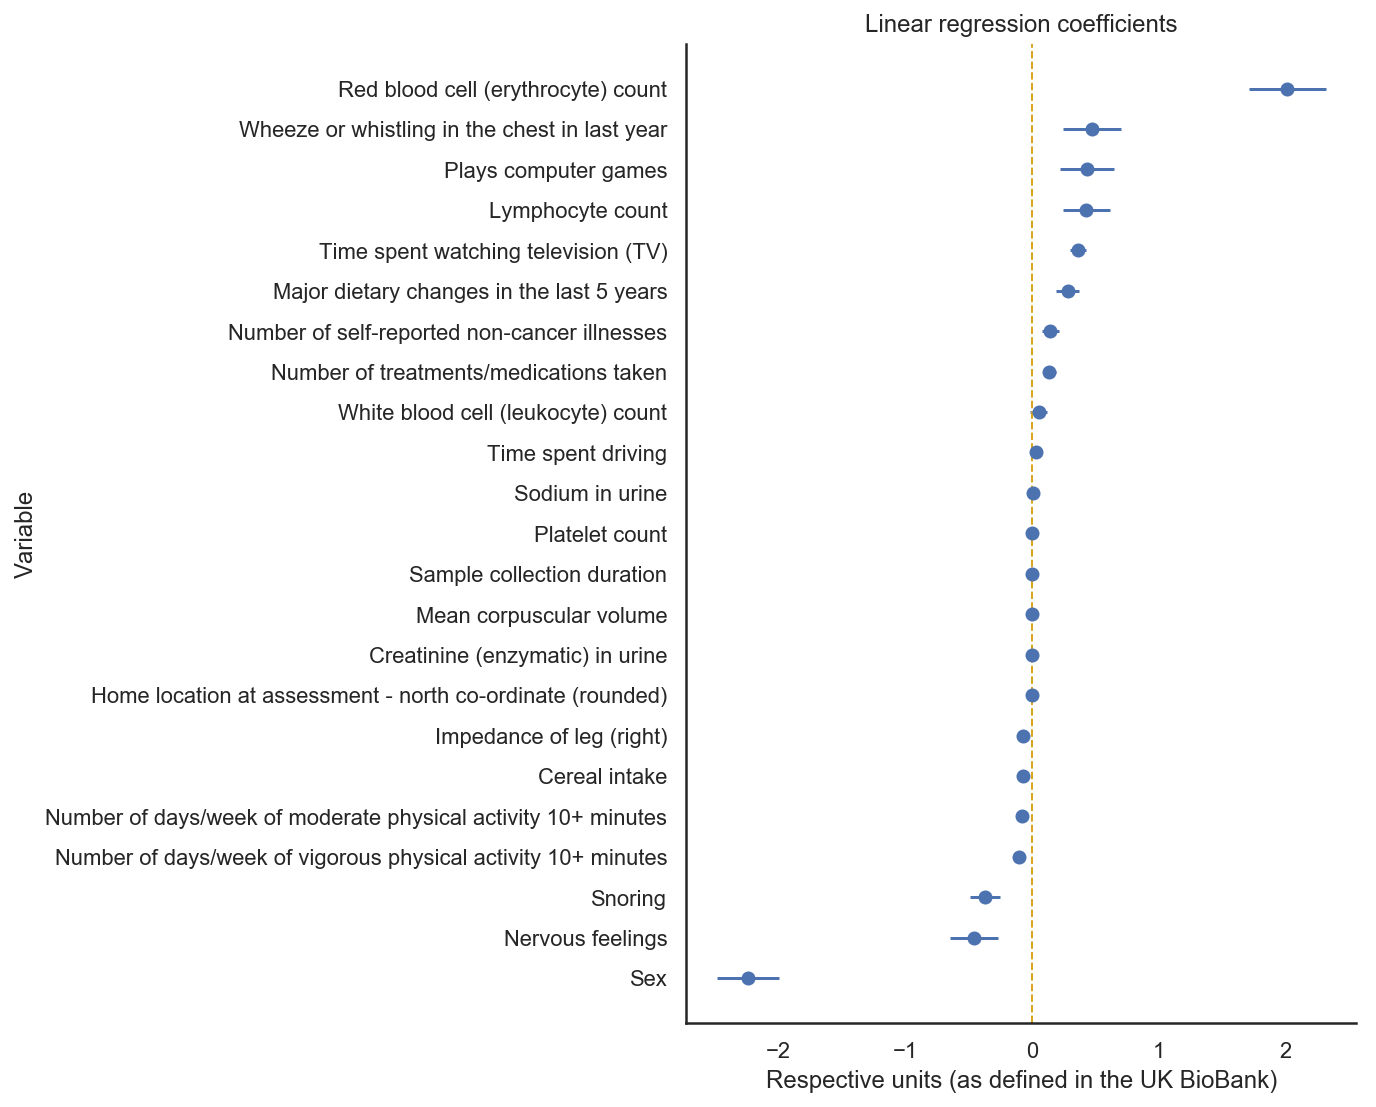

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt
fig8, ax8 = plt.subplots(figsize=(6, 9))

ax8.errorbar(data_inf_noint['mean'].values, data_inf_noint['feature'].values, xerr=data_inf_noint['error_interval'], fmt='o')
ax8.set_title('Linear regression coefficients')
sns.despine()
ax8.set_xlabel('Respective units (as defined in the UK BioBank)')
ax8.set_ylabel('Variable')
plt.axvline(x=0,color='goldenrod',linewidth=1,linestyle='--')
plt.savefig("linear_regression_coefficients_bootstrapped.pdf", dpi=800,bbox_inches='tight')

# Sensitivity Analysis 

- 100 Bootstrap samples to evaluate model selection robustness

In [38]:
results_bs=[]
for k in range(0,100): 
    model_selection_dataset = model_dataset.sample(frac=1,replace=True,random_state=k)
    train_stats = model_selection_dataset.describe()
    train_stats.pop("21001-0.0")  #BMI
    train_stats = train_stats.transpose()
    train_labels = model_selection_dataset.pop('21001-0.0')
    def norm(x):
        return (x - train_stats['mean']) / train_stats['std']
    normed_train_data = norm(model_selection_dataset)
    corr = normed_train_data.corr()
    upper = corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(np.abs(upper[column])> 0.8)]
    normed_train_data=normed_train_data.drop(to_drop, axis=1)
    X, y = normed_train_data,train_labels
    regLCV = LassoCV(eps=1e-4, n_alphas=1000,fit_intercept =False,precompute='auto',max_iter=100000, cv=10,n_jobs=-1, random_state=2).fit(X, y)
    reg1 = linear_model.Lasso(alpha=regLCV.alpha_)
    reg1.fit(normed_train_data, train_labels)
    final=zip(reg1.coef_,list(normed_train_data))
    Features_sorted_1=sorted(final, reverse=True)
    important=[x for x in Features_sorted_1 if x[0]!=0]
    Cl_keep=[get_def(x[1]) for x in important]
    results_bs.append(Cl_keep)

In [65]:
flat_list = [item for sublist in results_bs for item in sublist]
from collections import Counter
E=Counter(flat_list)
sorted_x = sorted(x.items(), key=lambda kv: kv[1])
sorted_x=list(map(list,zip(*sorted_x[::-1])))
sorted_x[1][:] = [x / 100 for x in sorted_x[1]]
sorted_x
data_tuples = list(zip(sorted_x[0],sorted_x[1]))
to_draw=pd.DataFrame(data_tuples, columns=['Variable','Probability'])

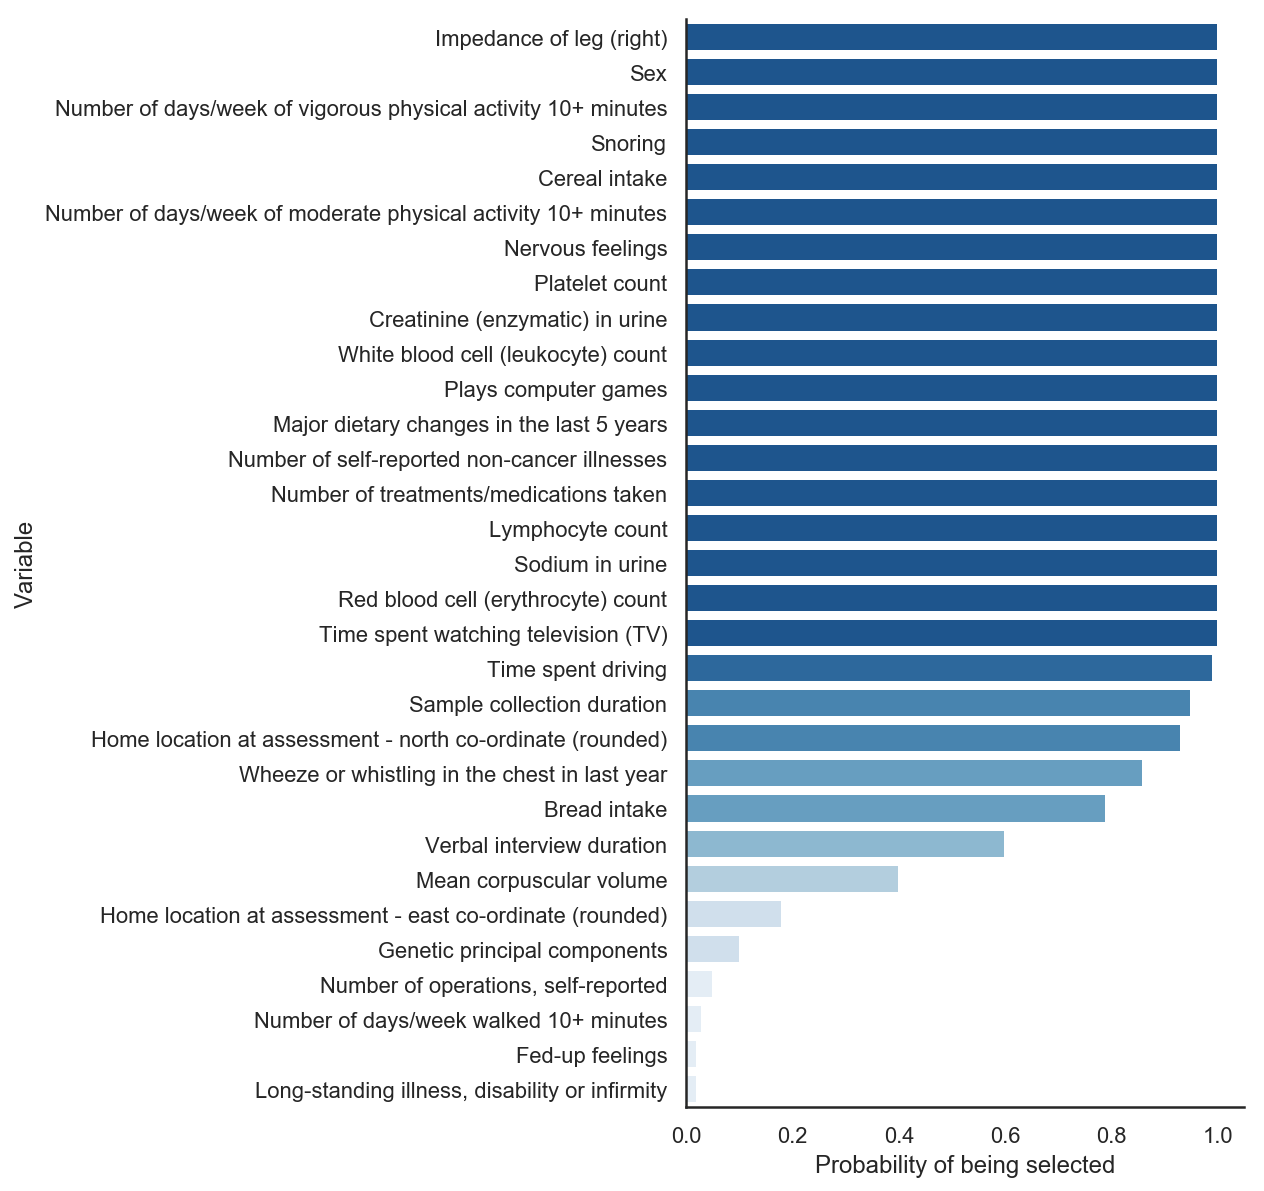

In [149]:
fig1,ax1=plt.subplots(figsize=(5, 10))
sns.despine()
sns.barplot("Probability","Variable",palette=sns.color_palette(List_colors),data=to_draw)   #Attention, the color palette won't work. please change.
plt.xlabel('Probability of being selected')
plt.savefig("bootstrap_sensitivity.pdf", dpi=1000, bbox_inches='tight')